# Simulating FEE on MC data

Develops the procedure to simulate the effect of FEE in NEXT MC data

In [79]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [81]:
import FEE as FE

In [82]:
import time

## Revised on:

In [83]:
print(time.strftime("%d/%m/%Y"))

07/11/2016


In [84]:
print(time.strftime("%H:%M:%S"))

17:24:26


###  Code exercized

In [85]:
!pep8 ../../Sierpe/FEE.py

In [86]:
!pyflakes ../../Sierpe/FEE.py

## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### Monte Carlo data

1. Running on electrons of fixed energy (40, 1250, 2500 keV)  in the center of chamber.
2. Nominal yield factor in current NEW conditions (7 bar, 7 kV in gate) is 574 photons/e
3. Monte Carlo yield factor 690 photons/e
4. Running of Kripton, Na, Tl, with yield factor 574 photons/e

In [87]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

#### List the files

In [88]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.roo

#### Open and inspect files

In [13]:
kr7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5','r+')

In [15]:
na7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5','r+')

In [16]:
Tl7bar = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5','r+')

In [18]:
e2500 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.2500.0keV.z250mm.next_1000.root.h5','r+')

In [19]:
e1250 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [20]:
e40 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [21]:
kr7bar

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(100, 12, 1200000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(100, 1792, 1200), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(686,), zlib(4))

#### loading the PMTRD vector: train of SPE in bins of 1 ns

In [22]:
pmtrd = e40.root.pmtrd

#### Plot pmtrd for the first event, first PMT

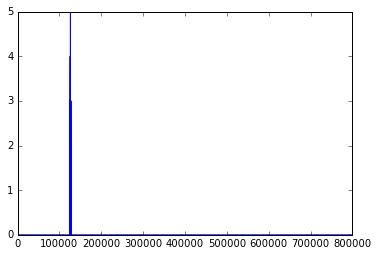

In [23]:
plt.plot(pmtrd[0,0])

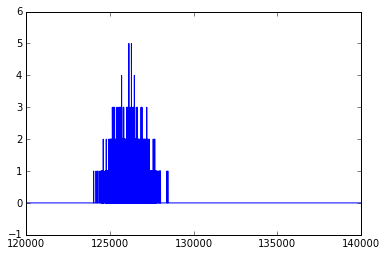

In [24]:
mpl.plts(pmtrd[0,0], signal_start=120000, signal_end=140000, offset=1)

In [25]:
print('area of kripton events in pe ={}'.format(np.sum(pmtrd[0,0])))

area of kripton events in pe =1210


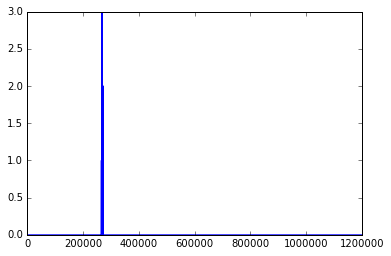

In [26]:
plt.plot(kr7bar.root.pmtrd[0,0])

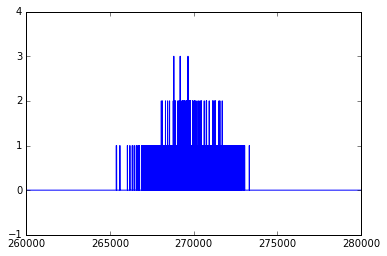

In [31]:
mpl.plts(kr7bar.root.pmtrd[0,0], signal_start=260000, signal_end=280000, offset=1)

In [33]:
print('area of kripton events in pe ={}'.format(np.sum(kr7bar.root.pmtrd[0,0])))

area of kripton events in pe =854


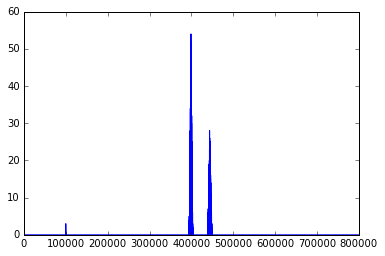

In [34]:
plt.plot(na7bar.root.pmtrd[0,0])

In [37]:
print('area of Na events in pe ={}'.format(np.sum(na7bar.root.pmtrd[0,0])))

area of Na events in pe =2760


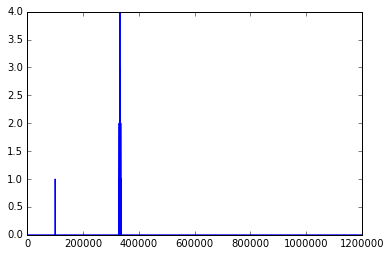

In [36]:
plt.plot(Tl7bar.root.pmtrd[0,0])

In [38]:
print('area of Tl events in pe ={}'.format(np.sum(Tl7bar.root.pmtrd[0,0])))

area of Tl events in pe =1037


### True energy distribution

In [45]:
ekr7bar = wfm.get_energy(kr7bar.root.pmtrd, event_list=range(99))

epmt = [ 854.  914.  987.  692.  692.  717.  706.  675.  666.  652.  683.  672.]
epmt = [ 1017.   916.   935.   714.   728.   684.   689.   651.   722.   670.
   739.   656.]
epmt = [ 1007.   983.   985.   695.   728.   696.   657.   674.   684.   694.
   721.   688.]
epmt = [  995.  1098.  1084.   723.   733.   666.   677.   681.   715.   747.
   742.   737.]
epmt = [ 1017.  1001.  1034.   653.   673.   734.   669.   722.   704.   678.
   703.   734.]
epmt = [ 1043.   994.  1079.   692.   712.   748.   719.   723.   764.   701.
   727.   697.]
epmt = [ 745.  736.  729.  627.  634.  576.  570.  569.  560.  579.  651.  637.]
epmt = [ 852.  859.  856.  759.  747.  666.  716.  704.  693.  719.  681.  685.]
epmt = [ 818.  823.  797.  664.  662.  649.  667.  651.  689.  703.  633.  695.]
epmt = [ 710.  727.  668.  572.  654.  583.  590.  537.  582.  545.  529.  610.]
epmt = [ 1022.  1012.   966.   713.   666.   716.   659.   629.   693.   657.
   695.   630.]
epmt = [ 1028.  1062.  1074.   

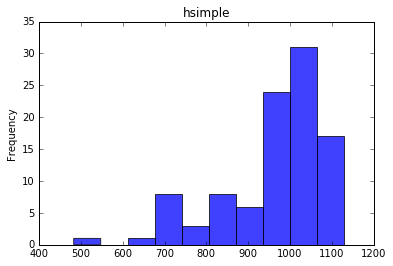

In [47]:
mpl.histo(ekr7bar[0].values,nbins=10) 

In [48]:
def plot_histograms(pmtdf,nbins=10):
    """
    Takes as input a df storing the PMT wf and plots the 12 PMT WF
    """
    plt.figure(figsize=(12, 12))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        mpl.histo(pmtdf[i].values,nbins=nbins)

    plt.show()

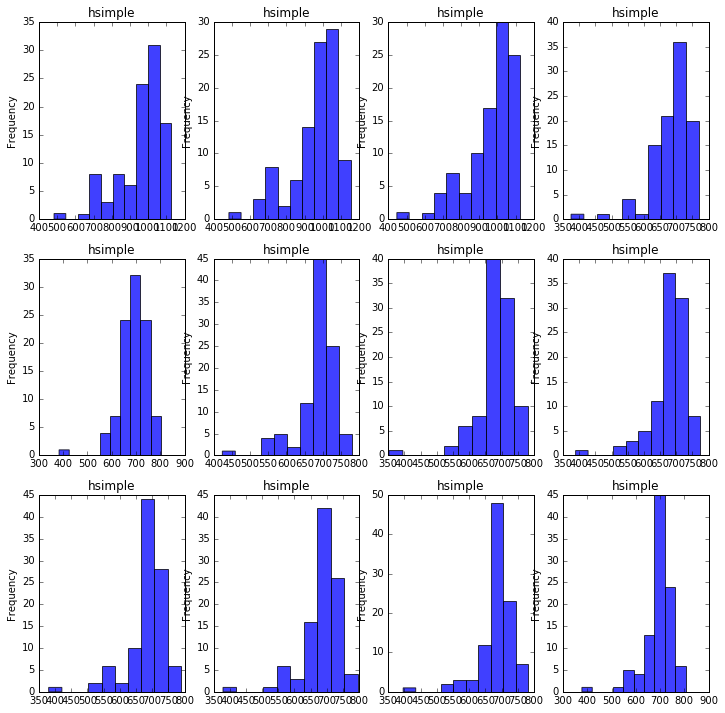

In [49]:
plot_histograms(ekr7bar,nbins=10)

In [50]:
ena7bar = wfm.get_energy(na7bar.root.pmtrd, event_list=range(99))

In [51]:
eTl7bar = wfm.get_energy(Tl7bar.root.pmtrd, event_list=range(99))

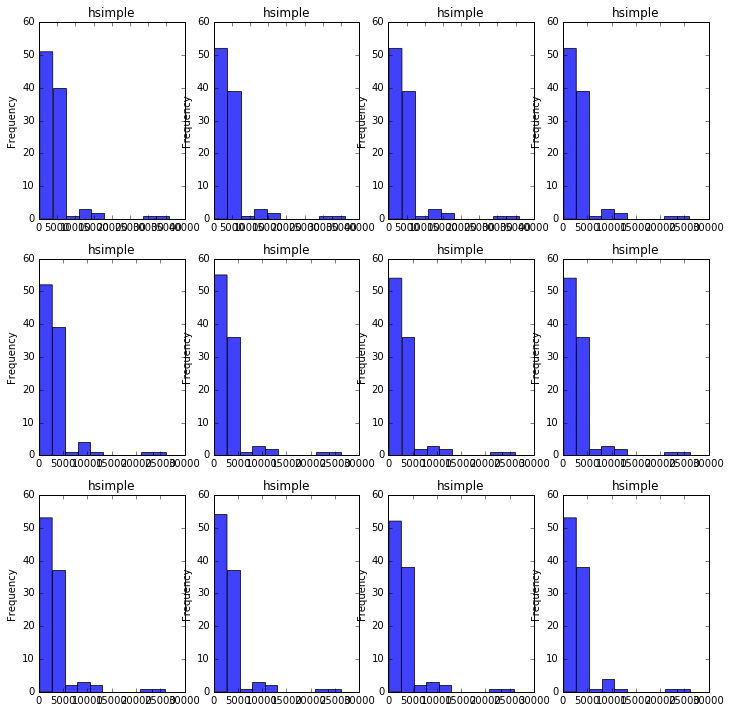

In [52]:
plot_histograms(ena7bar,nbins=10)

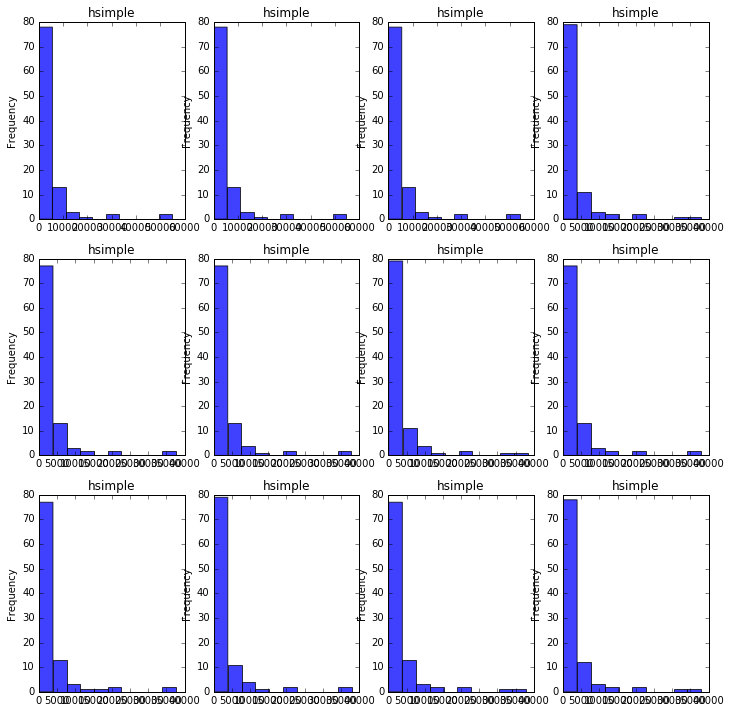

In [53]:
plot_histograms(eTl7bar,nbins=10)

#### signal_i : convolute pmtrd with spe

In [89]:
spe = FE.SPE()

In [90]:
spe


        (PMT gain = 1.7e+06, amplitude =    45 muA
         slope =  5.00 ns, flat =  1.00 ns)
        

#### Create FEE instance

In [91]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)

In [92]:
fee


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.54 muA,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =    0.31
        )
        

#### plot input function

In [93]:
signal_i = FE.spe_pulse_from_vector(spe, e40.root.pmtrd[0,0]) 

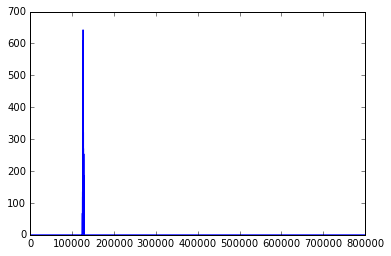

In [94]:
plt.plot(signal_i*FE.i_to_adc())   #plot input signal in adc counts

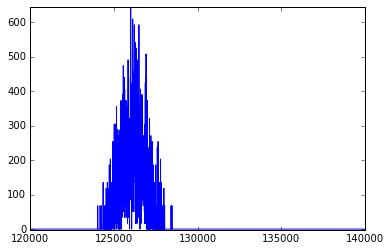

In [95]:
mpl.plts(signal_i*FE.i_to_adc(), signal_start=120000, signal_end=140000, offset=2)

### Decimate

#### sampling frequencies

In [99]:
f_sample1 = (1./(1*units.ns))

In [100]:
f_sample2 = (1./(25*units.ns))

In [101]:
f_sample1/units.MHZ

1000.0

In [102]:
f_sample2/units.MHZ

40.0

In [103]:
scale = int(f_sample1/f_sample2)

In [104]:
scale

25

### Decimation

In [105]:
signal_d = FE.daq_decimator(f_sample1, f_sample2, signal_i)

In [106]:
len(signal_i)

800000

In [107]:
len(signal_d)

32000

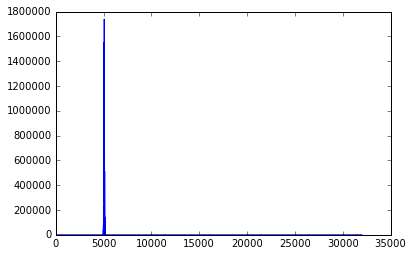

In [108]:
plt.plot(signal_d)

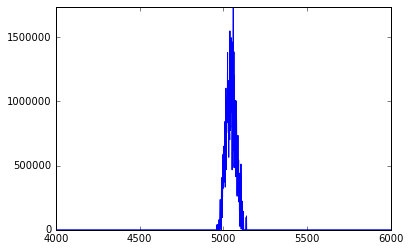

In [109]:
mpl.plts(signal_d, signal_start=4000, signal_end=6000, offset=2)

### Convolve with FEE

In [110]:
signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc()  #in adc counts

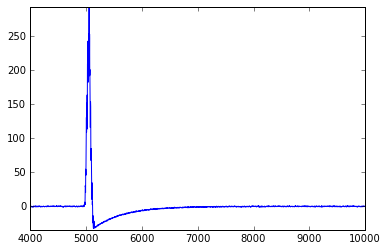

In [111]:
mpl.plts(signal_fee, signal_start=4000, signal_end=10000, offset=2)

### Add DAQ noise

In [112]:
signal_daq = FE.noise_adc(fee, signal_fee)

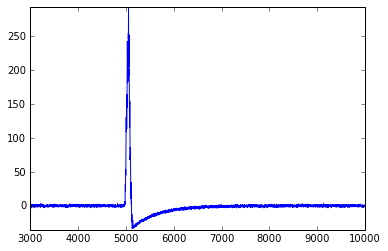

In [113]:
mpl.plts(signal_daq, signal_start=3000, signal_end=10000, offset=2)

### Total noise

In [114]:
print("Out Noise FEE (LSB_rms) = {}".format(np.std(signal_daq[3000:4000],ddof=1)))

Out Noise FEE (LSB_rms) = 0.871733454677


In [132]:
def fee_response(pmtrd, event=0):
    """
    input: pmtrd vector
    returns: a data frame with the PMT waveforms
    """
    spe = FE.SPE()
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    NPMT = pmtrd.shape[1]
    
    RWF = []
    BLRX = []
    for pmt in range(NPMT):
        signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units  
        signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
        signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc()  #in adc counts
        signal_daq = FE.noise_adc(fee, signal_fee)
        signal_blr = signal_d*FE.i_to_adc()
        
        #RWF.append(FE.OFFSET - signal_daq)
        RWF.append(signal_daq)
        BLRX.append(signal_blr)
    
    return np.array(RWF), np.array(BLRX)

In [133]:
RWF, BLR = fee_response(e40.root.pmtrd, event=0) 

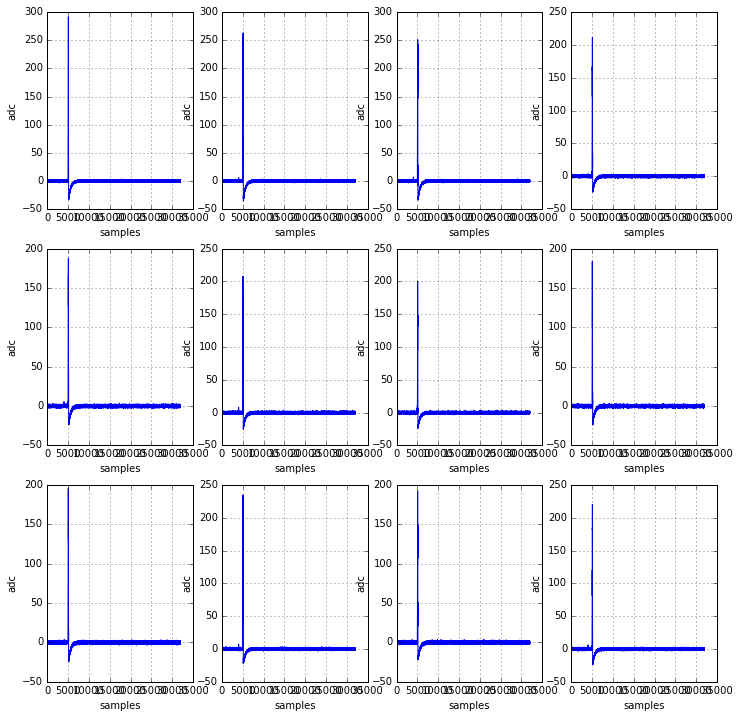

In [134]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=False, window_size=800)

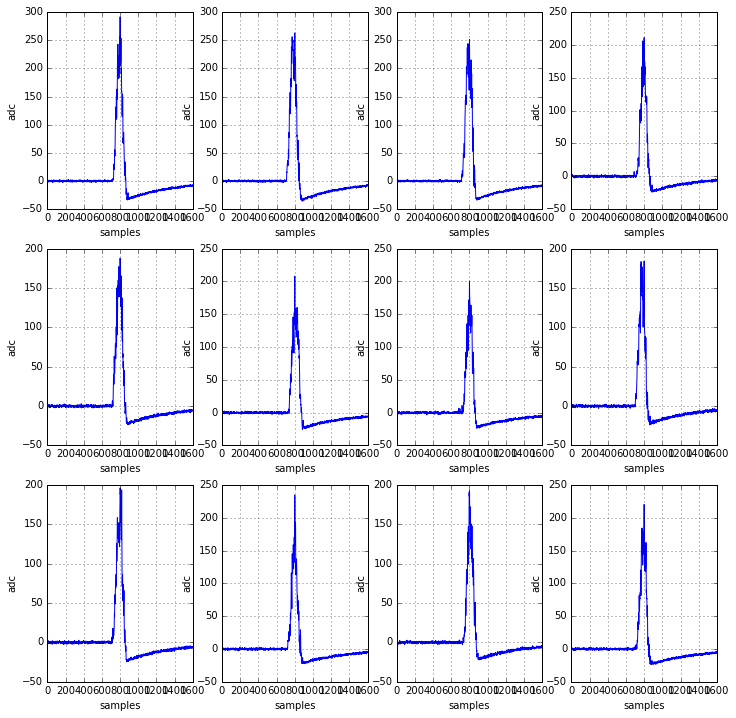

In [135]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=800)

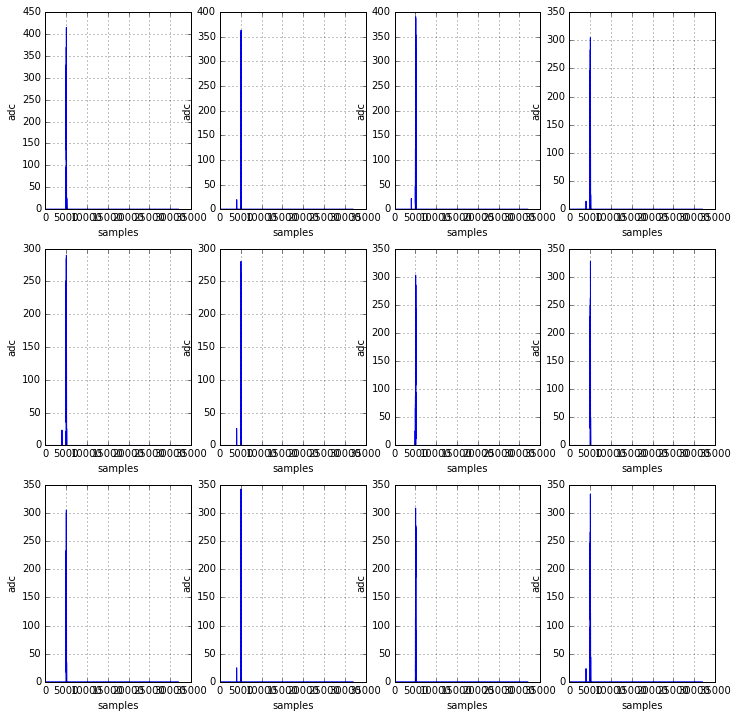

In [119]:
mpl.plot_waveforms(BLR, maxlen=0, zoom=False, window_size=800)

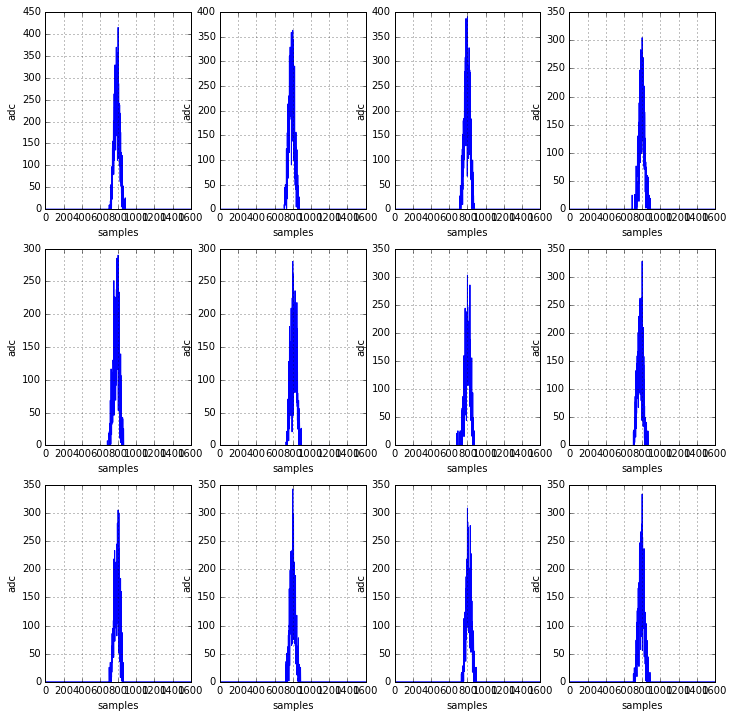

In [120]:
mpl.plot_waveforms(BLR, maxlen=0, zoom=True, window_size=800)

In [121]:
def ene_waveform(WF):
    ENE = [np.sum(wf) for wf in WF]
    return np.array(ENE)   

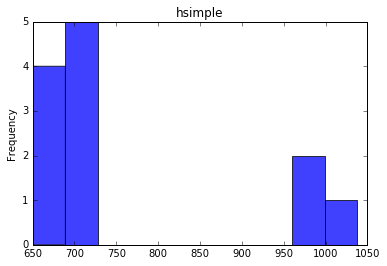

In [122]:
mpl.histo(ene_waveform(BLR/FE.ADC_TO_PES),10)

There is a block of PMTs with about 700 pes and another with ~1000 pes. Difference is only geometry. 

## Deconvolution

### Remove the effect of filter

#### cleaning filter

In [140]:
signal_daq = RWF[0]

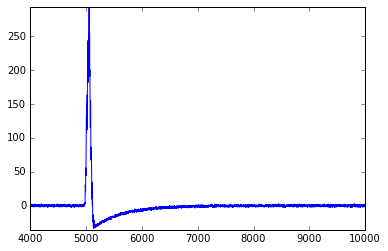

In [141]:
mpl.plts(signal_daq, signal_start=4000, signal_end=10000, offset=2)

In [142]:
signal_c = FE.signal_clean(fee, signal_daq)

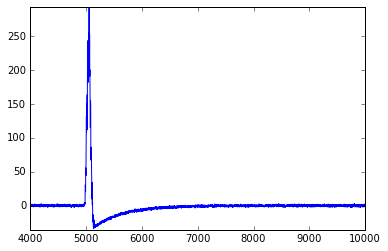

In [143]:
mpl.plts(signal_c, signal_start=4000, signal_end=10000, offset=2)

### For the MC with gaussian noise simple deconvolution is enough

In [144]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [145]:
signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)

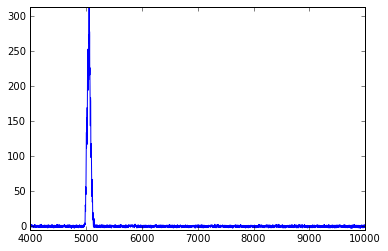

In [146]:
mpl.plts(signal_r, signal_start=4000, signal_end=10000, offset=2)

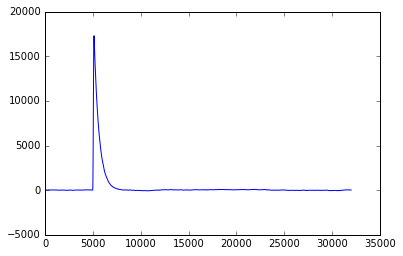

In [147]:
plt.plot(acum)

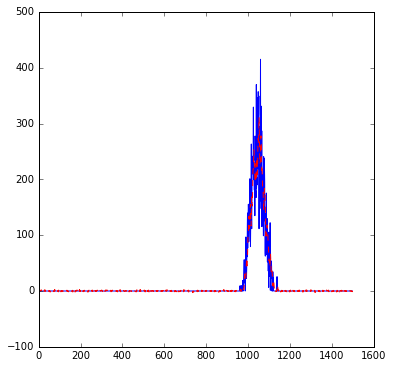

In [149]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4000:5500]*FE.i_to_adc())
plt.plot(signal_r[4000:5500],'r--', linewidth=1)
plt.show()

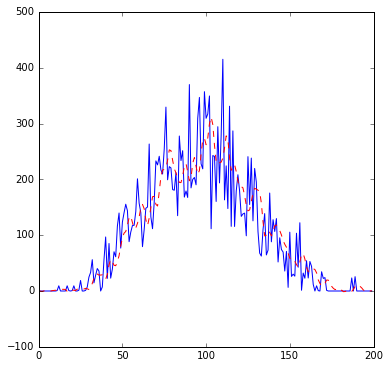

In [150]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:5150]*FE.i_to_adc())
plt.plot(signal_r[4950:5150],'r--', linewidth=1)
plt.show()

In [151]:
energy_mea=np.sum(signal_r[4950:5150])
energy_in=np.sum(signal_d[4950:5150]*FE.i_to_adc())
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 19874.1902873
Reconstructed Energy = 19888.5501332
Error in Energy Computation (%) = -0.0722537406089


In [152]:
RWF, BLR = fee_response(e1250.root.pmtrd, event=0) 

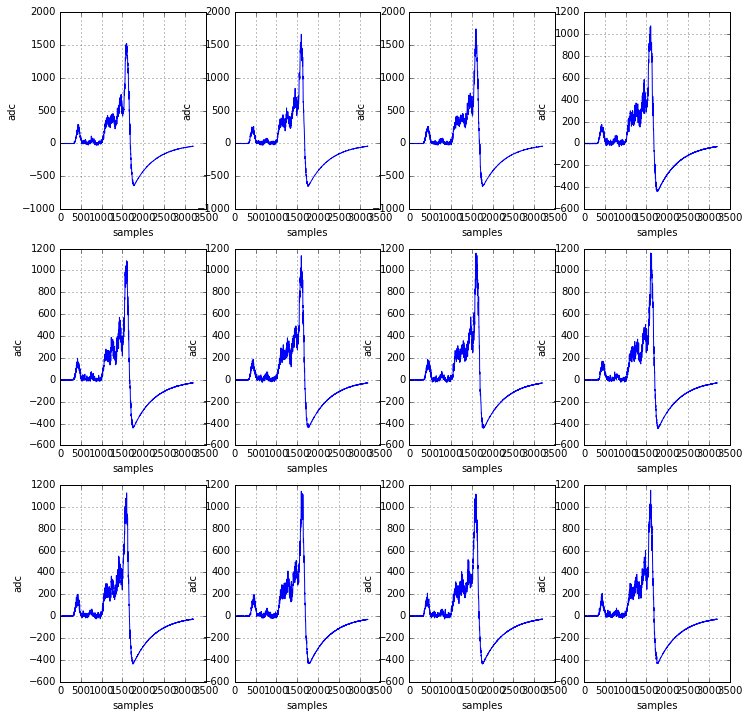

In [155]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

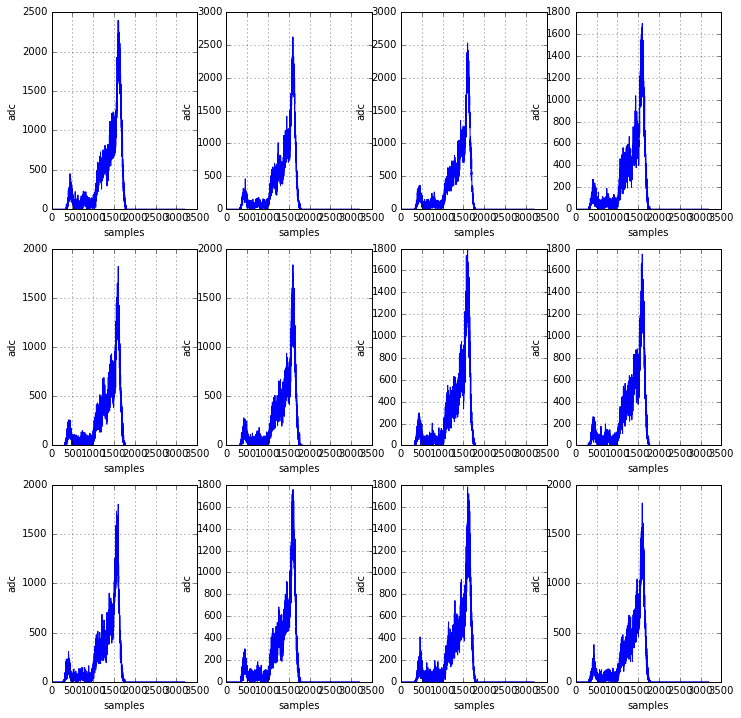

In [156]:
mpl.plot_waveforms(BLR, maxlen=0, zoom=True, window_size=1600)

In [178]:
def fee_response(h5f, event=0, pmt=0):
    """
    returns:
    input function (after daq decimation)
    convoluted function (after FEE)
    recovered function (after cleaning filter and BLR)
    all in adc counts
    """
    pmtrd = h5f.root.pmtrd
    spe = FE.SPE()
    signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event,pmt])  # in current units
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
    signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
    signal_fee = FE.signal_v_fee(fee, signal_d)*FE.v_to_adc(fee)  #in adc counts
    signal_daq = FE.noise_adc(fee, signal_fee)
    signal_c = FE.signal_clean(fee, signal_daq)
    signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)
    
    return signal_d*FE.i_to_adc(fee), signal_daq, signal_r

In [193]:
signal_d, signal_daq, signal_r = fee_response(e1250, event=10, pmt=0)

In [157]:
signal_d = BLR[0]
signal_daq = RWF[0]

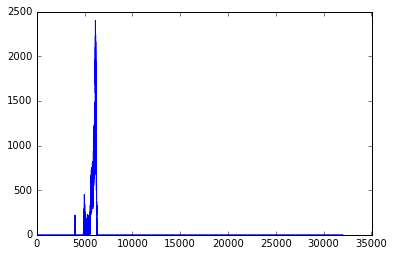

In [158]:
plt.plot(signal_d)

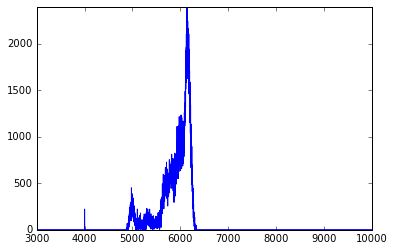

In [159]:
mpl.plts(signal_d, signal_start=3000, signal_end=10000, offset=2)

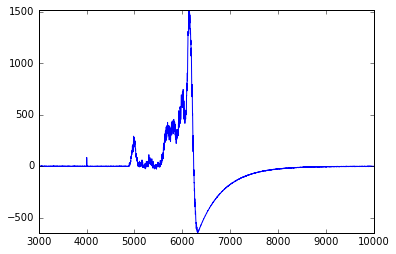

In [160]:
mpl.plts(signal_daq, signal_start=3000, signal_end=10000, offset=2)

In [161]:
print("Out Noise FEE (LSB_rms) = {}".format(np.std(signal_daq[3000:4000],ddof=1)))

Out Noise FEE (LSB_rms) = 0.905440341274


In [162]:
signal_c = FE.signal_clean(fee, signal_daq)
signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)

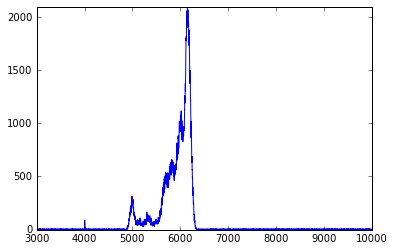

In [163]:
mpl.plts(signal_r, signal_start=3000, signal_end=10000, offset=2)

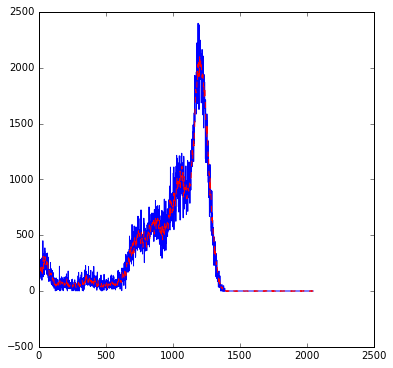

In [164]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[4950:7000])
plt.plot(signal_r[4950:7000],'r--', linewidth=1)
plt.show()

In [165]:
energy_mea=np.sum(signal_r[4950:7000])
energy_in=np.sum(signal_d[4950:7000])
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format(abs(energy_in-energy_mea)/energy_in*100))

Input Energy = 625890.818855
Reconstructed Energy = 626505.889792
Error in Energy Computation (%) = 0.0982712828718


In [166]:
RWF, BLR = fee_response(e2500.root.pmtrd, event=0) 

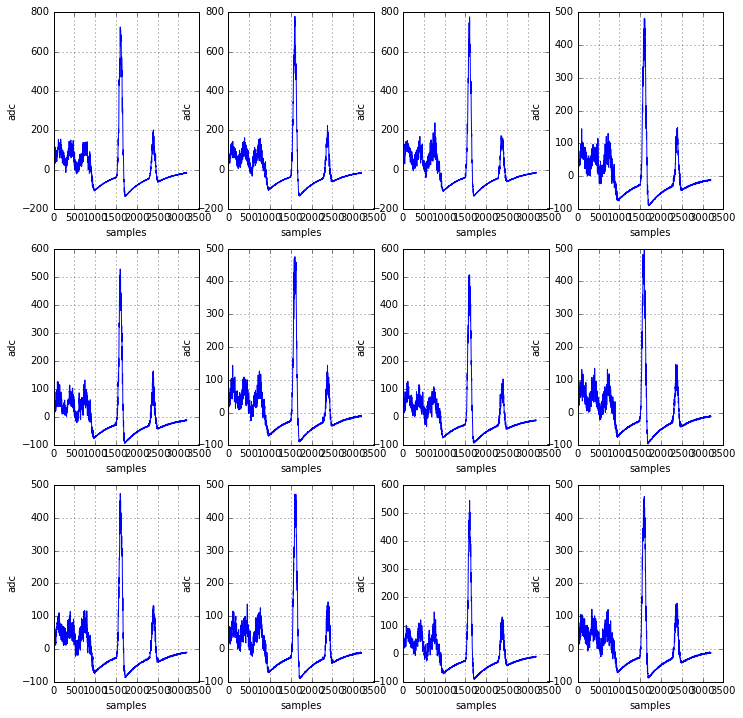

In [167]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=1600)

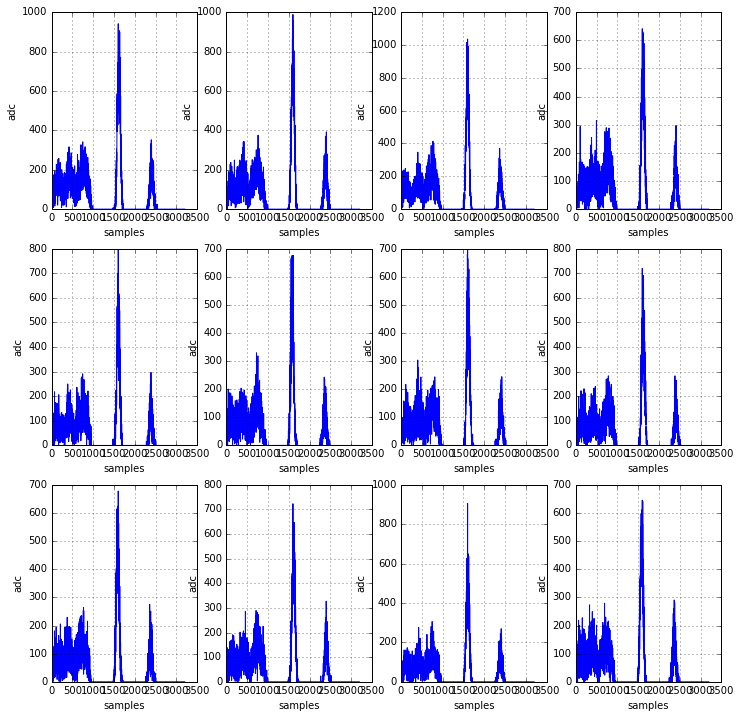

In [168]:
mpl.plot_waveforms(BLR, maxlen=0, zoom=True, window_size=1600)

In [169]:
signal_d = BLR[0]
signal_daq = RWF[0]

In [202]:
signal_d, signal_daq, signal_r = fee_response(e2500, event=100, pmt=0)

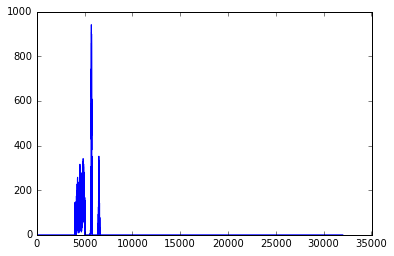

In [170]:
plt.plot(signal_d)

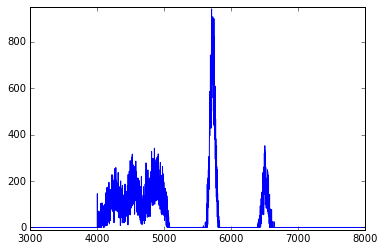

In [172]:
mpl.plts(signal_d, signal_start=3000, signal_end=8000, offset=10)

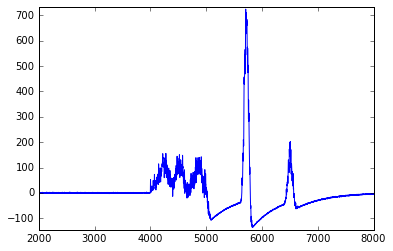

In [174]:
mpl.plts(signal_daq, signal_start=2000, signal_end=8000, offset=10)

In [175]:
signal_c = FE.signal_clean(fee, signal_daq)
signal_r, acum = deconv_simple(signal_c,coef=fee.freq_LHPFd*np.pi)

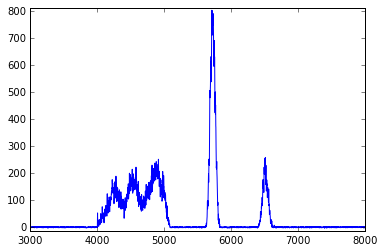

In [176]:
mpl.plts(signal_r, signal_start=3000, signal_end=8000, offset=10)

In [177]:
print("Out Noise FEE (LSB_rms) = {}".format(np.std(signal_daq[3000:4000],ddof=1)))

Out Noise FEE (LSB_rms) = 0.862338366578


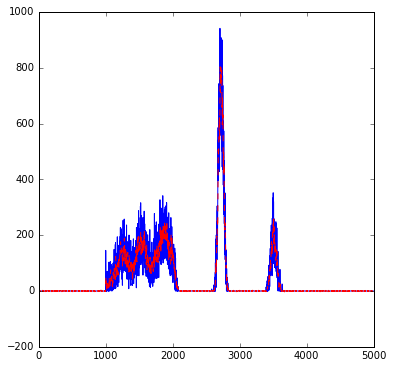

In [181]:
plt.figure(figsize=(6, 6))
plt.plot(signal_d[3000:8000])
plt.plot(signal_r[3000:8000],'r--', linewidth=1)
plt.show()

In [182]:
energy_mea=np.sum(signal_r[3000:8000])
energy_in=np.sum(signal_d[3000:8000])
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 214421.563923
Reconstructed Energy = 214303.29915
Error in Energy Computation (%) = 0.0551552608544


## Find s1 and s2

In [210]:
from scipy import signal as SGN

In [311]:
def find_s12(signal_i, blevt=1000, thr1=3, thr2=1.5):

    """
    1) compute baseline using the first blevt events
    2) compute noise rms using first blevt events
    3) detect start of signal if signal > sigma_start*rms_noise
    4) detect end of signal if signal < sigma_end*rms_noise
    5) label signal as s1 if len(signal) < 1mus (400 bins of 25 ns)
    6) label signal as s2 otherwise.
    """
    
    nm = blevt
    len_signal_i = len(signal_i)
    mau = np.zeros(nm, dtype=np.double)
    pulse_on = np.zeros(len_signal_i, dtype=np.int8)
    bmau = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch
#    allows to compute the baseline of the signal

    mau = SGN.lfilter(bmau,1, signal_i[0:nm])
    baseline = mau[nm-1]
    noise_rms = np.std(signal_i[0:nm],ddof=1)
    
    p_on = 0
    trigger_on = baseline + thr1
    trigger_off = baseline + thr2
    S12L = []
    n = 0
    for k in range(nm,len_signal_i):
        pulse_on[k] = p_on
    
        if signal_i[k] > trigger_on:
            if p_on == 0: # pulse just started
                p_on = 1
                S12E = [signal_i[k] - baseline]
                S12T = [k * FE.t_sample]
                S12 = {}
                S12['e_adc'] =  S12E
                S12['t_ns'] = S12T
                S12L.append(S12)
            else:
                S12 = S12L[n]
                S12['e_adc'].append(signal_i[k] - baseline)
                S12['t_ns'].append(k * FE.t_sample)
        
        elif signal_i[k] > trigger_off and p_on == 1:
                S12 = S12L[n]
                S12['e_adc'].append(signal_i[k] - baseline)
                S12['t_ns'].append(k * FE.t_sample)
                
        elif signal_i[k] < trigger_off and p_on == 1:
                n+=1
                p_on = 0
            
    return  baseline, noise_rms, pulse_on, S12L


In [221]:
baseline, noise_rms, pulse_on, S12 = find_s12(signal_r)
mr = np.amax(signal_r)

baseline = -0.0657867632688 adc, noise_rms = 0.861903125011 adc


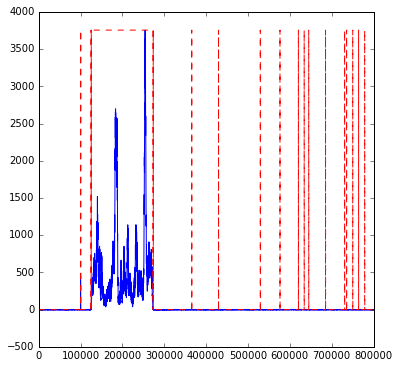

In [222]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(len(signal_r))*FE.t_sample, signal_r)
plt.plot(np.arange(len(signal_r))*FE.t_sample, pulse_on*mr, 'r--', linewidth=1)
print('baseline = {} adc, noise_rms = {} adc'.format(baseline, noise_rms))
plt.show()

In [324]:
baseline, noise_rms, pulse_on, S12L = find_s12(signal_r,thr1=5, thr2=3.0)
mr = np.amax(signal_r)

In [325]:
def plot_s12_search(signal_r, baseline, noise_rms, pulse_on):
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(len(signal_r))*FE.t_sample, signal_r)
    plt.plot(np.arange(len(signal_r))*FE.t_sample, pulse_on*mr, 'r--', linewidth=1)
    print('baseline = {} adc, noise_rms = {} adc'.format(baseline, noise_rms))
    plt.show()

baseline = -0.0657867632688 adc, noise_rms = 0.861903125011 adc


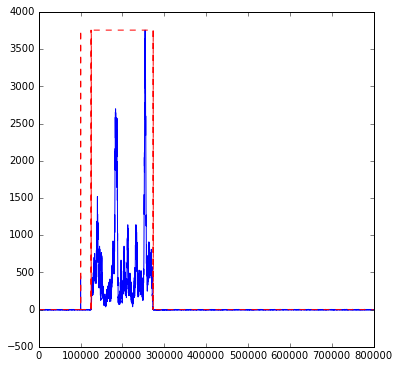

In [326]:
plot_s12_search(signal_r, baseline, noise_rms, pulse_on)

In [289]:
len(S12L)

4

In [256]:
def classify_S12(S12L):
    for s12 in S12L:
        s12e = np.array(s12['e_adc'])
        emax = np.amax(s12e)
        print('len of s12e = {} ns, max = {} adc '.format(len(s12e)*FE.t_sample, emax))
        

In [257]:
classify_S12(S12L)

len of s12e = 425.0 ns, max = 451.953460958 adc 
len of s12e = 250.0 ns, max = 20.1847911523 adc 
len of s12e = 147900.0 ns, max = 3756.53162552 adc 
len of s12e = 300.0 ns, max = 35.8858006248 adc 


In [386]:
def stats_S12(h5f, event_list, thr1=5, thr2=1.0, s12min=2, lenmax = 1000, pmt=0):
    s12L = []
    s12E = []
    s12EM = []
    s12N = []
    S1 = []
    S2 = []
    for event in event_list:
        signal_d, signal_daq, signal_r = fee_response(h5f, event=event, pmt=pmt)
        baseline, noise_rms, pulse_on, S12L = find_s12(signal_r,thr1=thr1, thr2=thr2)
        
        #print(len(S12L))
        if len(S12L) != s12min:
            continue
        
        s12N.append(len(S12L))
        
        for s12 in S12L:
            s12e = np.array(s12['e_adc'])
            emax = np.amax(s12e)
            s12L.append(len(s12e))
            s12EM.append(np.amax(s12e))
            s12E.append(np.sum(s12e))
            if len(s12e) > lenmax:
                S2.append(s12)
            else:
                S1.append(s12)
    return S1, S2, np.array(s12N), np.array(s12L), np.array(s12EM), np.array(s12E)

In [387]:
S1, S2, s12N, s12L, s12EM, s12E = stats_S12(e2500,range(100), thr1=5, thr2=3.0,s12min = 2)

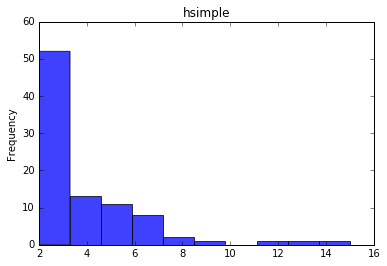

In [347]:
mpl.histo(s12N, nbins=10)

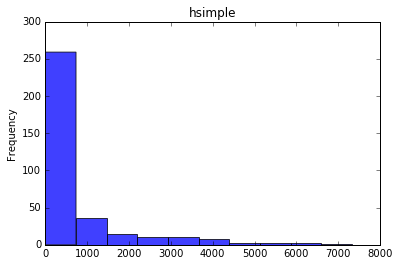

In [348]:
mpl.histo(s12L, nbins=10)

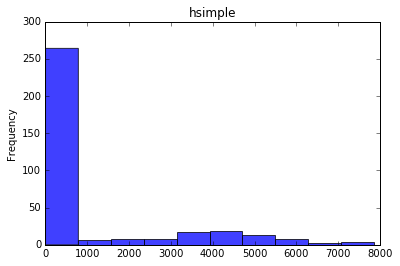

In [349]:
mpl.histo(s12EM, nbins=10)

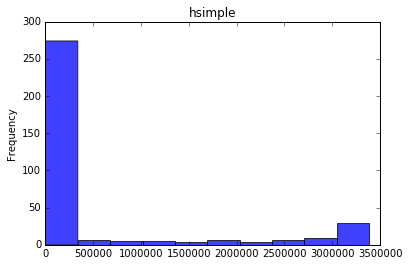

In [350]:
mpl.histo(s12E, nbins=10)

In [390]:
len(S1)

27

In [358]:
def stats_S1(S1L):
    s12L = []
    s12E = []
    s12EM = []
    for s12 in S1L:
        s12e = np.array(s12['e_adc'])
        emax = np.amax(s12e)
        s12L.append(len(s12e))
        s12EM.append(np.amax(s12e))
        s12E.append(np.sum(s12e))
        
    return np.array(s12L), np.array(s12EM), np.array(s12E)

In [388]:
s12L, s12EM, s12E = stats_S1(S1)

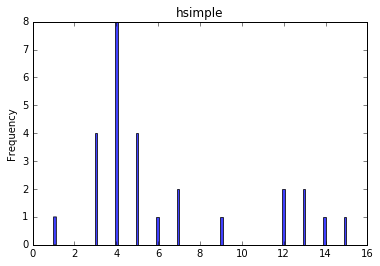

In [389]:
mpl.histo(s12L, nbins=100)

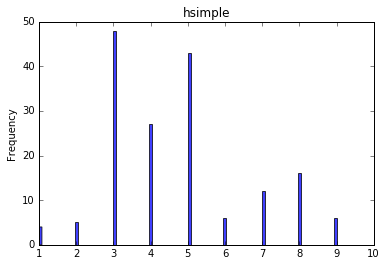

In [385]:
mpl.histo(s12L[np.where(s12L < 10)], nbins=100)

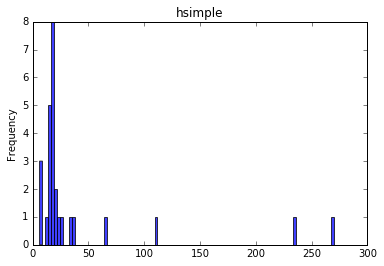

In [391]:
mpl.histo(s12EM, nbins=100)

In [ ]:
mpl.histo(s12EM, nbins=100) np.sum(pulse[np.where(pulse > thr)])

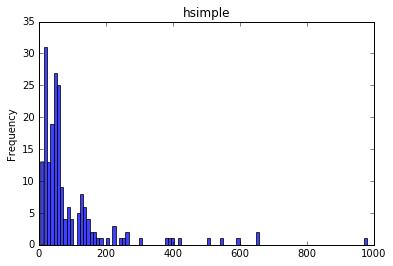

In [383]:
mpl.histo(s12E[np.where(s12E < 1000)], nbins=100)

In [392]:
s12L, s12EM, s12E = stats_S1(S1)

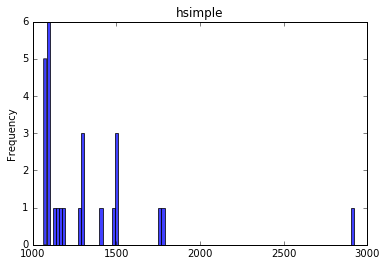

In [370]:
mpl.histo(s12L, nbins=100)

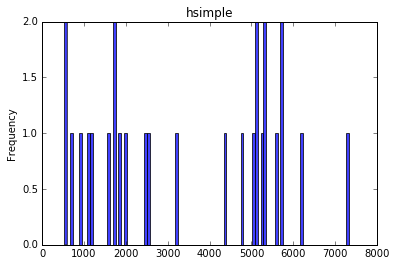

In [371]:
mpl.histo(s12EM, nbins=100)

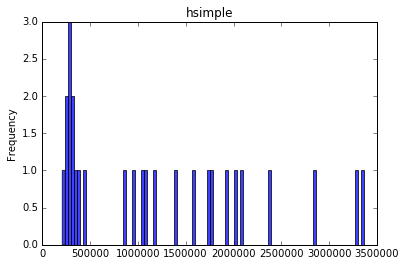

In [372]:
mpl.histo(s12E, nbins=100)

In [275]:
def select_S12(S12L):
    S1L =[]
    S2L =[]
    for s12 in S12L:
        if len(s12) == 2:
            S1L.append(s12[0])
            S2Lappend(s12[1])
    return S1L, S2L            

In [276]:
s1L, s2L= select_S12(S12L)

KeyError: 0

In [ ]:
def get_s1_s2(S

## Statistics

In [ ]:
def blr_energy_resolution(h5f, event_list, pmt=0):
    for event in event_list:
        signal_d, signal_daq, signal_r = fee_response(h5f, event=event, pmt=pmt)
        